## Загрузка Pandas и очистка данных

In [6939]:
import pandas as pd
import datetime
from ast import literal_eval

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

RANDOM_SEED = 42

In [6940]:
data = pd.read_csv('main_task.csv')

## Смотрим содержимое датасета

In [6941]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
3102,id_379,Paris,"['French', 'European', 'Contemporary', 'Fusion...",380.0,4.0,$$$$,2090.0,"[['Wonderful Ambience', 'Almost Perfect'], ['1...",/Restaurant_Review-g187147-d804935-Reviews-Les...,d804935
25725,id_3033,Madrid,['Delicatessen'],3035.0,4.0,$$ - $$$,34.0,"[['Great food, even better postres', 'Great pl...",/Restaurant_Review-g187514-d7260058-Reviews-Sw...,d7260058
17481,id_153,Milan,['Italian'],154.0,4.0,$,825.0,"[['Osteria with character/characters', 'Great ...",/Restaurant_Review-g187849-d1391266-Reviews-Os...,d1391266
36824,id_6219,London,['Cafe'],6228.0,5.0,$,15.0,"[['Best crispy bacon sandwich in Brighton', 'G...",/Restaurant_Review-g186338-d1021137-Reviews-Pi...,d1021137
18563,id_1382,Milan,"['Italian', 'Pizza', 'Seafood', 'Mediterranean...",1384.0,4.0,$,158.0,"[['Good for the value', 'Great, simple food at...",/Restaurant_Review-g187849-d2386013-Reviews-Da...,d2386013


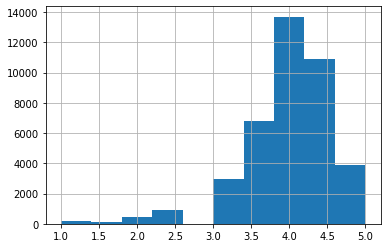

In [6942]:
data['Rating'].hist(bins=10)

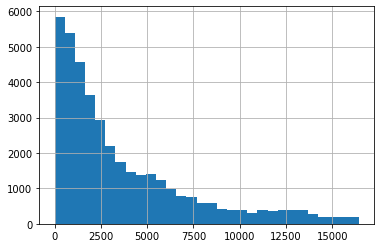

In [6943]:
data['Ranking'].hist(bins=30)

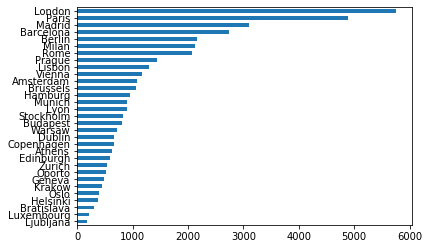

In [6944]:
data['City'].value_counts(ascending=True).plot(kind='barh')

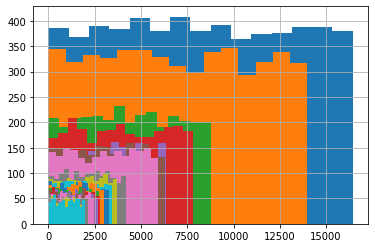

In [6945]:
# посмотрим на топ 10 городов по рангу
for x in (data['City'].value_counts())[0:20].index:
    data['Ranking'][data['City'] == x].hist(bins=15)
plt.show()

## Обрабатываем имеющиеся, создаём новые признаки.

In [6946]:
# Минимум для города (правда это везде двойка)
number_of_reviews_change = data['Number of Reviews'].groupby(data['City']).min()

# Если отзыв пустой
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
# Заполняем отсутствующее значение
data['Number of Reviews'] = data['Number of Reviews'].fillna(data.City.apply(lambda x: number_of_reviews_change[x]))

#Находим относительное значение количества отзывов
number_of_reviews_max = data['Number of Reviews'].groupby(data['City']).max()
data['Number of Reviews_MAX'] = data.City.apply(lambda x: number_of_reviews_max[x])
data['Number of Reviews new'] = data['Number of Reviews'] / data['Number of Reviews_MAX'] 

In [6947]:
def getPriceRange(item):
    if item == '$':
        return 1
    if item == '$$$$':
        return 3
    if item == '$$ = $$$':
        return 2
    return 2

# Добавляем столбец с информацией об отсутствующих значениях поля Price Range
data['Price Range NAN'] = data['Price Range'].isna().astype('uint8')

# Заменяем пустые значения
data['Price Range'] = data['Price Range'].apply(getPriceRange)

#Считаем среднюю цену по городу без учёта пустых значений
mean_price_range = (data[data['Price Range NAN'] == 0]['Price Range']).groupby(data['City']).mean()
data['Price Range mean'] = data['City'].apply(lambda x: mean_price_range[x])

# Делаем dummies из Price Range
data = pd.get_dummies(data, columns=['Price Range'])

In [6948]:
# Обрабатываем поле Ranking
rank_max = data['Ranking'].groupby(data['City']).max()
data['Rank_max'] = data.City.apply(lambda x: rank_max[x])

data['Ranking_new'] = data['Ranking'] / data['Rank_max'] 

In [6949]:
#Преобразовываем поле Reviews, обрабатываем nan и пустые []
def work_with_reviews(reviews_str):
    lst = literal_eval(reviews_str.replace('nan','[\'\'],[\'\']').replace('[]', '[\'\']'))
    return lst 

data['Reviews'] = data['Reviews'].apply(work_with_reviews)

In [6950]:
# Добавляем среднюю длину отзыва, отсутствующие отзывы заменяем на медианное значение

def count_avg_len_review(review_lst):
    reviews = review_lst[0]
    lst_len = []
    if len(reviews) > 0:
        for review in reviews:
            if len(review) > 0:
                lst_len.append(len(review))
    else:
        return None
    if len(lst_len) == 0:
        return None
    return sum(lst_len) / len(lst_len)

data['avg_len_reviews'] = data['Reviews'].apply(count_avg_len_review)
data['avg_len_reviews'] = data['avg_len_reviews'].fillna(float(df['avg_len_reviews'].median() ))

In [6951]:
# Добавляем максимальную дату отзыва
def found_max_date(review_lst):
    review_dates = review_lst[1]
    dates = []
    if len(review_dates) > 0:
        for date in review_dates:
            if len(date) > 0:
                dates.append(datetime.datetime.strptime(date, '%m/%d/%Y'))
            else:
                dates.append(datetime.datetime.strptime('01/01/2000', '%m/%d/%Y'))
    else:
        dates.append(datetime.datetime.strptime('01/01/2000', '%m/%d/%Y'))
    
    max_date = max(dates)
    
    return max_date
            
data['max_date'] = data['Reviews'].apply(found_max_date)

last_review_date = data['max_date'].max()
#слишком старые отзывы, ограничим десятью годами, приравняем к отстутствующим
data['max_date'] = data['max_date'].apply(lambda x: min( (last_review_date - x).days, 3650) )

In [6952]:
#Добавляем количество отзывов

def count_len_reviews(review_lst):
    reviews = review_lst[0]
    lst_len = []
    if len(reviews) > 0:
        for review in reviews:
            if len(review) > 0:
                lst_len.append(len(review))
    else:
        return 0
    
    if len(lst_len) == 0:
        return 0
    
    return len(lst_len)

data['Num of text reviews'] = data['Reviews'].apply(count_len_reviews)


In [6953]:
#Добавляем разницу между последними отзывами, делаем максимальное значение 1825 дней
def found_reviews_dates_diff(review_lst):
    review_dates = review_lst[1]
    dates = []
    if len(review_dates) > 0:
        for date in review_dates:
            if len(date) > 0:
                dates.append(datetime.datetime.strptime(date, '%m/%d/%Y'))
            else:
                dates.append(datetime.datetime.strptime('01/01/2000', '%m/%d/%Y'))
    else:
        dates.append(datetime.datetime.strptime('01/01/2000', '%m/%d/%Y'))
    
    if len(dates) == 2:
        reviews_dates_diff = min((max(dates) - min(dates)).days, 1825)
    else:
        return 1825
    
    return reviews_dates_diff
            
data['reviews_dates_diff'] = data['Reviews'].apply(found_reviews_dates_diff)

In [6954]:
# Добавляем количество кухонь. По умолчанию ставим 3 кухни

#data['Cuisine Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')
data['Cuisine Style'] = data['Cuisine Style'].fillna("['', '', '']") 
data['Cuisine Style'] = data['Cuisine Style'].apply(literal_eval)
data['Cuisines'] = data['Cuisine Style'].apply(len)

In [6955]:
# city_cuisines = (data[data['Cuisine Style_isNAN'] == 0]['Cuisines']).groupby(data['City']).mean()
# #Отностиельное количество кухонь
# data['Cuisines new'] = (data['Cuisines'] > data['City'].apply(lambda x: city_cuisines[x])).astype('uint8')

In [6956]:
# Добавляем dummies по городу
data = pd.get_dummies(data, columns=['City',], dummy_na=True)

In [6957]:
# cities_population = {'Amsterdam': 1149000,
#  'Athens':3153000,
#  'Barcelona':5586000,
#  'Berlin':3562000,
#  'Bratislava':435000,
#  'Brussels':2081000,
#  'Budapest':1768000,
#  'Copenhagen':794128,
#  'Dublin':1228000,
#  'Edinburgh':537000,
#  'Geneva':615000,
#  'Hamburg':1845000,
#  'Helsinki':1305000,
#  'Krakow':768731,
#  'Lisbon':2957000,
#  'Ljubljana':277220,
#  'London':9304000,
#  'Luxembourg':122273,
#  'Lyon':1719000,
#  'Madrid':6618000,
#  'Milan':3140000,
#  'Munich':1538000,
#  'Oporto':1313000,
#  'Oslo':693491,
#  'Paris':2148000,
#  'Prague':1306000,
#  'Rome':4257000,
#  'Stockholm':1633000,
#  'Vienna':1930000,
#  'Warsaw':1783000,
#  'Zurich':1395000
# }

# data['City_population'] = data.City.apply(lambda x: cities_population[x])

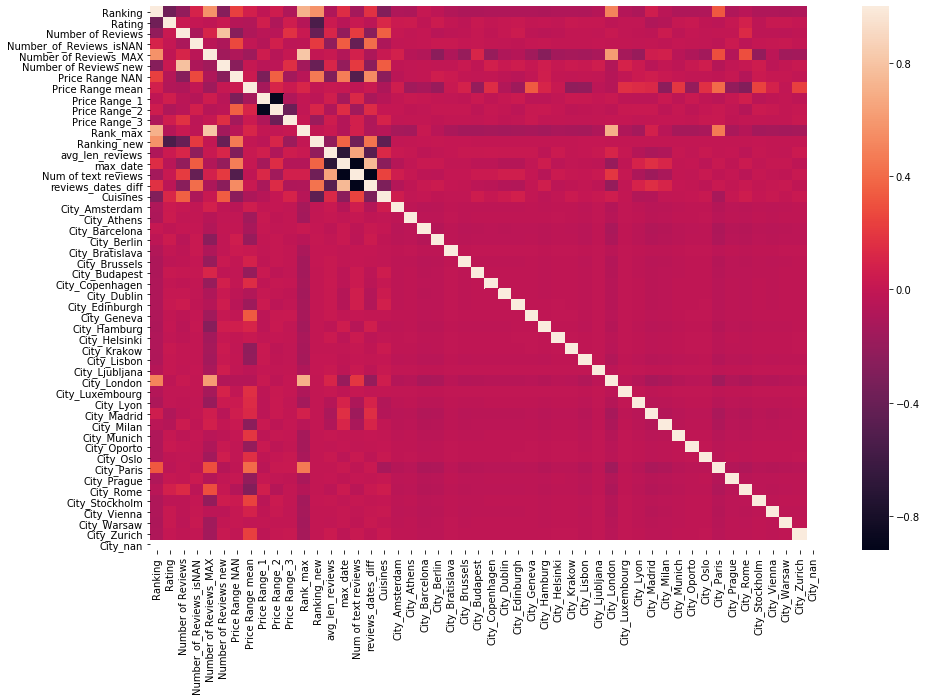

In [6958]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.corr(),)

In [6959]:
# Удаляем ненужные столбцы
data = data.drop(columns=['Restaurant_id', 'Cuisine Style','Reviews','URL_TA','ID_TA', 'Ranking', 'Number of Reviews_MAX'])

## Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [6960]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = data.drop(['Rating'], axis = 1)
y = data['Rating']

In [6961]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [6962]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

## Создаём, обучаем и тестируем модель

In [6963]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [6964]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [6965]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20104949999999996


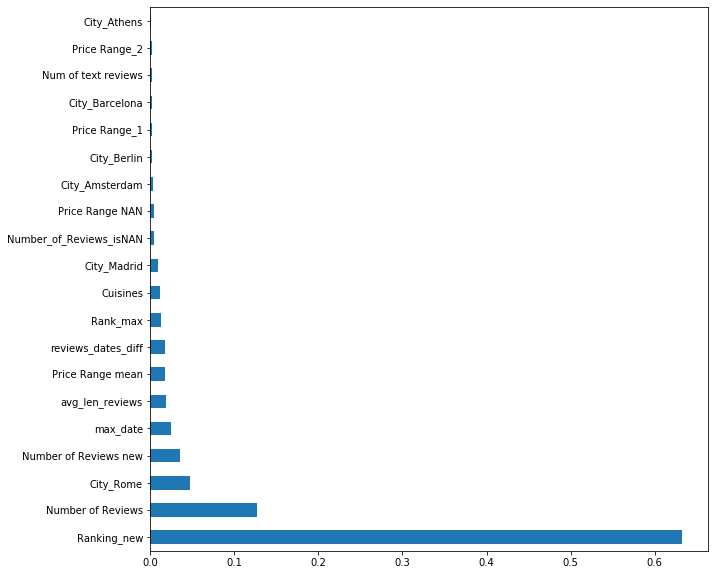

In [6966]:
# выводим самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')